In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm, trange
tqdm.pandas()
import math, time
import matplotlib.pyplot as plt
%cd /home/jeroen/repos/traffic-scheduling/network/
from generate import generate_grid_network, generate_simple_instance
from automaton import Automaton
from exact import solve

/home/jeroen/repos/traffic-scheduling/network


In [2]:
import torch
from torch import argmax
import torch.optim as optim
import torch.nn as nn
from torch.nn.functional import cross_entropy
from torch.utils.data import TensorDataset, DataLoader, random_split

# Crossing time scheduling in network of intersections

We analyze the efficiency of constructive heuristics for the crossing time scheduling problem in grid-like (like Manhattan) networks of intersections.

## Generate training data

Generate a small grid network and some instances with a fixed number of arrivals per route. In the next section, we solve these instances to optimality using mixed-integer linear programming, from which we later extract the expert demonstration as observation-action pairs. We use the term observations because it is the result of a static non-parameterized transformation on which the parameterized model is then fitted.

In [3]:
data = pd.DataFrame([
    [5,  2, 1],
    [10, 2, 1],
    [15, 2, 1],
], columns=['n_arrivals', 'grid_m', 'grid_n'])

Generate some grid networks and store it together with the routes.

In [4]:
data[['G', 'routes']] = data.apply(lambda row: generate_grid_network(row['grid_m'], row['grid_n']), axis=1, result_type='expand')

We can load the train and test data sets from disk. Skip the next computations and the next section when the optimal solutions have already been computed previously.

In [5]:
train, test = {}, {}
for i, row in data.iterrows():
    train[i] = pd.read_pickle(f'data/train_{i}.pkl')
    test[i] = pd.read_pickle(f'data/test_{i}.pkl')

For each specification, we generate some training instances and some test instances that will be used in the final optimality evaluation.

In [5]:
N_train, N_test = 100, 100
train, test = {}, {}
for i, row in data.iterrows():
    f = lambda: generate_simple_instance(row['G'], row['routes'], arrivals_per_route=row['n_arrivals'])
    train[i] = pd.DataFrame(zip([f() for _ in range(N_train)]), columns=['instance'])
    test[i] = pd.DataFrame(zip([f() for _ in range(N_test)]), columns=['instance'])

## Compute optimal solutions

In [6]:
timelimit_opt = 60

def solve_instance(x):
    res = solve(x['instance'], timelimit=timelimit_opt)
    return res['y'], res['obj'], res['done'], res['gap'], res['time']

start = time.time()
for i, row in data.iterrows():
    print(f"set {row['n_arrivals']}, grid size {row['grid_m']} x {row['grid_n']}")
    cols = ['opt_y', 'opt_obj', 'opt_done', 'opt_gap', 'opt_time']
    train[i][[*cols]] = train[i].progress_apply(solve_instance, axis=1, result_type='expand')
    test[i][[*cols]] = test[i].progress_apply(solve_instance, axis=1, result_type='expand')

    # save to disk
    train[i].to_pickle(f'data/train_{i}.pkl')
    test[i].to_pickle(f'data/test_{i}.pkl')
print(f'total computation time: {time.time() - start}')

set 5, grid size 2 x 1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set 10, grid size 2 x 1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set 15, grid size 2 x 1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

total computation time: 10651.22307729721


Next, we use the optimal crossing time schedules to backtrack the actions for the automaton that lead to this optimal schedule.

In [26]:
def compute_route_order(row):
    """Compute the order in which vehicles pass each intersection
    based on the order of the route to which the vehicles belong."""
    instance = row['instance']
    schedule = row['opt_y']
    route_order = {}
    indices = schedule.keys() # (r, k, v) tuples
    for v in instance['G'].intersections:
        route_order[v] = sorted(filter(lambda x: x[2] == v, indices), key=lambda i: schedule[i])
        route_order[v] = list(map(lambda x: x[0], route_order[v])) # take route index r
    return [route_order] # to prevent unpacking in DataFrame

for i, row in data.iterrows():
    train[i][['opt_route_order']] = train[i].apply(compute_route_order, axis=1, result_type='expand')
    # save to disk
    train[i].to_pickle(f'data/train_{i}.pkl')

## Exhaustive policy

In [6]:
from util import routes_at_intersection

def earliest_route(automaton, v):
    """Get the route with the earliest arrival at intersection v."""
    first_vehicles = { r: automaton.D.nodes[r, k, v]['LB']
                      for r in automaton.routes_at_intersection[v]
                      for k in automaton.order_indices[r] }
    return min(first_vehicles, key=first_vehicles.get)

In [7]:
from networkx import topological_sort

def intersection_done(automaton, v):
    return all(len(automaton.unscheduled[r, v]) == 0 for r in automaton.routes_at_intersection[v])

def threshold_heuristic(instance, threshold=0):
    automaton = Automaton(instance)

    # visit intersections in topological order
    # execute exhaustive policy at intersection v
    G = instance['G']
    for v in topological_sort(G.subgraph(G.intersections)):
        routes = list(automaton.routes_at_intersection[v]) # copy as list

        # start with the route with the earliest vehicle
        r = earliest_route(automaton, v)
        automaton.step(r, v)
        while not intersection_done(automaton, v):
            # next route candidate
            r_next = routes[(routes.index(r) + 1) % len(routes)]
            
            # next vehicle exists on current route
            if len(automaton.unscheduled[r, v]) > 0:
                k = automaton.last_scheduled_order[r, v]
                # earliest crossing time of next vehicle on this route
                LB_next = automaton.D.nodes[r, k + 1, v]['LB']
                # check threshold condition
                if automaton.D.nodes[r, k, v]['LB'] + instance['rho'] + threshold >= LB_next:
                    # continue on this route
                    automaton.step(r, v)
                    continue
            else:
                routes.remove(r)

            r = r_next
            automaton.step(r, v)

    return automaton.get_obj()

In [8]:
def eval_exhaustive(test, set_id):
    tqdm.pandas(desc=f"{set_id} evaluating")
    return test.progress_apply(lambda x: threshold_heuristic(x['instance'], threshold=0), axis=1).mean()

In [9]:
data['exhaustive_obj'] = data.apply(lambda row: eval_exhaustive(test[row.name], row.name), axis=1)

0 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

1 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

2 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

## RNN heuristic

### Model definition

The observations for the RNN model are the collection of _horizons_ for each route-intersection pair and flags that indicate which route was served during the last step of the automaton.

In [10]:
class RNNModel(torch.nn.Module):
    def __init__(self, n_crossings, max_horizon):
        """n_crossings = number of (route, intersection) pairs"""
        super().__init__()
        self.n_crossings = n_crossings
        self.max_horizon = max_horizon

        self.rnn_out = 32
        self.rnns = [ nn.RNN(1, self.rnn_out).cuda() for _ in range(n_crossings) ]
        self.network = nn.Sequential(
            nn.Linear(self.n_crossings * (1 + self.rnn_out), 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, self.n_crossings),
        )

    def forward(self, obs):
        N = obs.size()[0] # batch size

        # take ragged tensor of horizons and apply rnn for each lane
        embedding = torch.zeros((N, self.n_crossings, 1 + self.rnn_out))
        
        for n in range(N):
            for c in range(self.n_crossings):
                # first number is last scheduled route flag
                last = int(obs[n, c, 0].item())
                embedding[n, c, 0] = last

                # second number indicates length of the horizon
                length = int(obs[n, c, 1].item())
                if length == 0:
                    continue

                # rest of sequence is actual horizon
                horizon = obs[n, c, 2:2+length]
                # reverse ("flip up down") the horizon
                inp = torch.flipud(horizon)
                # add dimension as required by RNN
                out, _ = self.rnns[c](torch.unsqueeze(inp, 1))
                # take the output at the last step as the rest of the embedding                
                embedding[n, c, 1:] = out[-1]

        flattened = torch.flatten(embedding, 1, 2)
        return self.network(flattened.cuda())

    def state_transform(self, automaton):
        # compute minimum LB of unscheduled vehicles per intersection
        min_LB = {}
        for v in automaton.G.intersections:
            LBs = []
            for r in automaton.routes_at_intersection[v]:
                if len(automaton.unscheduled[r, v]) > 0:
                    k = automaton.unscheduled[r, v][0]
                    LBs.append(automaton.D.nodes[r, k, v]['LB'])
            if len(LBs) == 0:
                continue
            min_LB[v] = min(LBs)

        # # compute minimum LB across all unscheduled nodes in disjunctive graph
        # LBs = []
        # for node, data in automaton.D.nodes(data=True):
        #     if not data['done']:
        #         LBs.append(data['LB'])
        # min_LB = min(LBs)

        # construct the (truncated) horizons
        obs = np.zeros((self.n_crossings, self.max_horizon))
        lengths = np.empty((self.n_crossings, 1))
        # flag indicating whether the route is the last scheduled
        last = np.empty((self.n_crossings, 1))

        for i, (r, v) in enumerate(automaton.crossing_indices):
            full_horizon = [automaton.D.nodes[r, k, v]['LB'] for k in automaton.unscheduled[r, v]]
            horizon_length = min(len(automaton.unscheduled[r, v]), self.max_horizon)
            lengths[i] = horizon_length
            # subtract minimal LB and truncate to max_horizon
            if horizon_length > 0:
                obs[i, :horizon_length] = np.array(full_horizon[:horizon_length]) - min_LB[v]

            if automaton.last_scheduled_route[v] is not None:
                last[i] = int(automaton.last_scheduled_route[v] == r)
            else:
                last[i] = 0

        # create ragged array; first number is "last route flag", second number indicates length of the horizon
        out = np.hstack([last, lengths, obs])
        out = np.expand_dims(out, axis=0) # to allow stacking with actions
        return torch.as_tensor(out, dtype=torch.float, device=torch.device('cuda'))

    def inverse_action_transform(self, automaton, r, v):
        out = automaton.crossing_indices.index((r, v))
        return torch.as_tensor(out, dtype=torch.float, device=torch.device('cuda'))

    def action_transform(self, automaton, out):
        # mask invalid actions (set to -inf)
        for r, v in automaton.crossing_indices:
            if automaton.crossing_done[r, v]:
                i = automaton.crossing_indices.index((r, v))
                out[i] = -torch.inf
        # greedy inference
        i = argmax(out)
        # translate index back to actual action
        r, v = automaton.crossing_indices[i]
        return r, v

    def heuristic(self, automaton):
        """Perform the actual trained heuristic."""
        return self.action_transform(automaton, self.forward(self.state_transform(automaton)).squeeze())

### Training with imitation learning

Note that the global order of actions is not unique: the order in which intersections are considered does not matter for the final schedule. Therefore, we can pick any or multiple sequences of intersections and replay the corresponding sequence of actions on the automaton to generate the corresponding sequence of observation-action pairs that act as the expert demonstration. For example, we can randomly select some next intersection that is not yet done. Another possible approach is to add for each possible next intersection the next action that leads to the given optimal schedule.

In [33]:
def extract_state_action_pairs(train, model, set_id):
    """N is the number of desired state-action pairs. We should rather say
    "observation"-action pair, because the static transformation is applied."""
    states, actions = [], []
    for _, row in tqdm(train.iterrows(), desc=f"{set_id} extracting", total=train.shape[0], leave=False):
        instance = row['instance']
        # deep copy of route_order with reversed lists to use as stacks
        route_order = { v: list(reversed(row['opt_route_order'][v])) for v in row['opt_route_order'] }

        # backtrack observations and actions for the optimal schedule
        automaton = Automaton(instance)
        # keep track of which intersections still have unscheduled vehicles
        pending_intersections = list(route_order.keys())
        while not automaton.done:        
            # # add action for each pending intersection
            # for v in pending_intersections:
            #     r = route_order[v][-1]
            #     # record (transformed) state-action pair
            #     states.append(model.state_transform(automaton))
            #     actions.append(model.inverse_action_transform(automaton, r, v))

            # randomly choose which action is actually executed
            #v = choice(pending_intersections)
            # pick fixed order of intersections
            v = pending_intersections[0]
            r = route_order[v].pop()
            states.append(model.state_transform(automaton))
            actions.append(model.inverse_action_transform(automaton, r, v))
            # perform action
            automaton.step(r, v)
    
            # remove pending intersection when done
            if len(route_order[v]) == 0:
                pending_intersections.remove(v)

    return states, actions

As a sanity check, we verify the correctness of the generated expert demonstration by replaying the first few actions and checking whether we end up with the same objective as the first instance in the train set.

In [34]:
row = train[0].iloc[0] # first instance of first data set
automaton = Automaton(row['instance'])
model = RNNModel(len(automaton.crossing_indices), 10) # some dummy model

# extract and replay actions
_, actions = extract_state_action_pairs(pd.DataFrame(row).T, model, 0)
for action in actions:
    r, v = automaton.crossing_indices[int(action.item())]
    automaton.step(r, v)

opt_y = row['opt_y'] # check with optimal schedule
for node, LB in automaton.D.nodes.data('LB'):
    assert math.isclose(LB, opt_y[node]), "crossing times do not match"

assert automaton.done, "automaton not done"
assert math.isclose(row['opt_obj'], automaton.get_obj()), "final objectives do not match"

0 extracting:   0%|          | 0/1 [00:00<?, ?it/s]

Main training loop with fixed number of total batches to process and validation (in terms of imitation loss) after a given number of batches. It might be more sensible to compute validation in terms of scheduling performance.

In [47]:
from random import choice
from copy import deepcopy

neural_train_losses = []
neural_val_losses = []
neural_train_times = {}

# instead of epochs, we provide the total number of individual training steps,
# to support fair comparison across different training data sets
total_steps = 1000
# compute validation loss each time this number of steps has been processed
val_steps = 20
# we define both the above numbers globally, because we need it to determine
# the correct time epochs when plotting the validation losses

def train_rnn(train, model, set_id):    
    start = time.time()

    states, actions = extract_state_action_pairs(train, model, set_id)

    batch_size = 20
    val_frac = 0.1 # fraction of state-action pairs used for validation

    state_action_pairs = TensorDataset(torch.vstack(states), torch.vstack(actions))
    train_set, val_set = random_split(state_action_pairs, [1 - val_frac, val_frac])    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set)

    learning_rate = 5e-4
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    params = []
    step = 0
    with tqdm(total=total_steps, desc=f"{set_id} training", leave=False) as pbar:
        while True:
            for s, a in train_loader:
                # perform a single training step
                model.train()
                optimizer.zero_grad()
                loss = cross_entropy(model(s), a.squeeze().long())
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

                step += 1
                pbar.update(1)
                
                if step % val_steps == 0:
                    # store current model parameters        
                    params.append(model.state_dict())
                    # validate current model
                    model.eval()
                    val_loss = 0
                    for s, a in val_loader:
                        val_loss += cross_entropy(model(s).squeeze(), a.squeeze().long())
                    val_losses.append(val_loss.detach().cpu() / len(val_loader)) # average over validation set

                if step >= total_steps: break # ...out of inner loop
            if step >= total_steps: break # ...out of outer loop

    # select model with minimal validation loss
    i = val_losses.index(min(val_losses))
    model.load_state_dict(params[i])

    # record data for reporting
    neural_train_times[set_id] = time.time() - start
    neural_train_losses.append(train_losses)
    neural_val_losses.append(val_losses)

    return model

### Evaluate recurrent heuristic

In [48]:
def eval_rnn(train, test, set_id):
    # get number of crossings, which is number of actions
    automaton = Automaton(train['instance'][0])
    n_crossings = len(automaton.crossing_indices)
    # maximum number of vehicle arrivals to "look ahead"
    max_horizon = 10
    
    model = RNNModel(n_crossings, max_horizon).cuda()
    model = train_rnn(train, model, set_id)
    model.eval()

    def eval_scheduling(row):
        automaton = Automaton(row['instance'])
        while not automaton.done:       
            # execute learned heuristic
            automaton.step(*model.heuristic(automaton))
        return automaton.get_obj()

    tqdm.pandas(desc=f"{set_id} evaluating")
    return test.progress_apply(eval_scheduling, axis=1, result_type='expand').mean()

In [49]:
data['rnn_obj'] = data.apply(lambda row: eval_rnn(train[row.name], test[row.name], row.name), axis=1)

0 extracting:   0%|          | 0/100 [00:00<?, ?it/s]

0 training:   0%|          | 0/1000 [00:00<?, ?it/s]

0 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

1 extracting:   0%|          | 0/100 [00:00<?, ?it/s]

1 training:   0%|          | 0/1000 [00:00<?, ?it/s]

1 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

2 extracting:   0%|          | 0/100 [00:00<?, ?it/s]

2 training:   0%|          | 0/1000 [00:00<?, ?it/s]

2 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

In [50]:
# take mean objective and running time over all test instances
data['opt_obj'] = data.apply(lambda row: test[row.name]['opt_obj'].mean(), axis=1)
data['opt_time'] = data.apply(lambda row: test[row.name]['opt_time'].mean(), axis=1)

# compute (relative) approximation ratio
data['rnn_gap'] = data.apply(lambda row: row['rnn_obj'] / row['opt_obj'], axis=1)
data['exhaustive_gap'] = data.apply(lambda row: row['exhaustive_obj'] / row['opt_obj'], axis=1)

In [51]:
data

,n_arrivals,grid_m,grid_n,G,routes,exhaustive_obj,rnn_obj,opt_obj,opt_time,rnn_gap,exhaustive_gap
0,5,2,1,"((0, 1), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1...","[[(1, 0), (1, 1), (1, 2)], [(2, 0), (2, 1), (2...",1584.487821,1420.569441,1392.240404,0.047162,1.020348,1.138085
1,10,2,1,"((0, 1), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1...","[[(1, 0), (1, 1), (1, 2)], [(2, 0), (2, 1), (2...",4968.527842,4465.307702,4361.579953,4.385951,1.023782,1.139158
2,15,2,1,"((0, 1), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1...","[[(1, 0), (1, 1), (1, 2)], [(2, 0), (2, 1), (2...",10008.157617,9062.722242,8826.650516,51.024113,1.026745,1.133857


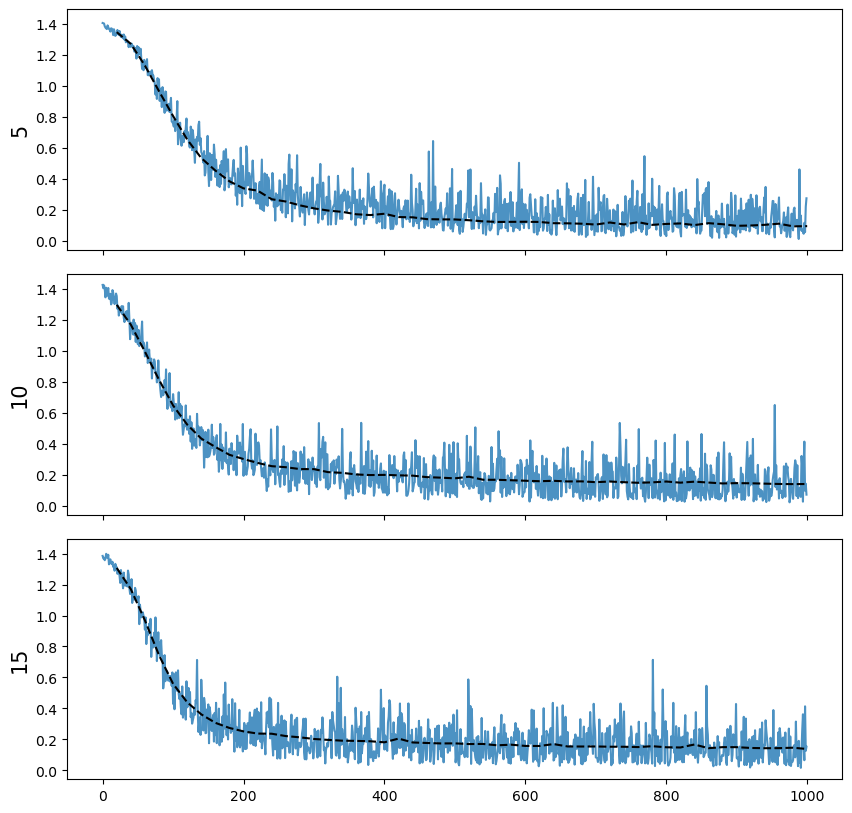

In [52]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(nrows=len(neural_train_losses), ncols=1, hspace=0.1, wspace=0.1)
axes = gs.subplots(sharex=True, sharey=True)
for ax, train_losses, val_losses in zip(axes.T.flatten(), neural_train_losses, neural_val_losses):
    ax.plot(train_losses, alpha=0.8, label='training')
    val_t = np.array(range(1, 1 + total_steps // val_steps)) * val_steps
    ax.plot(val_t, val_losses, '--k', label='validation')
    #ax.set(xlabel='step')
    
for ax, label in zip(axes, ['5', '10', '15']):
    ax.set_ylabel(label, size=15)

#plt.legend() # single legend in last ax
plt.savefig(f'neural_fit.pdf')
plt.show()

## GNN heuristic

### Model definition

For the observations of the GNN model, we **copy the whole disjunctive graph** for each state. Alternatively, we could use some sort of masking for non-final states.

In [ ]:
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d
from torch_geometric.nn import GINConv

class GNNModel(torch.nn.Module):

    def __init__(self):
        super().__init__()
        # we need a separate layer for the first iteration, because the initial
        # feature dimension in different from the node embedding dimension
        lin0 = Sequential(Linear(1, 16), ReLU(), Linear(16, 32), ReLU(), BatchNorm1d(32))
        self.gin0 = GINConv(lin0, train_eps=True)

        lin1 = Sequential(Linear(32, 32), ReLU(), Linear(32, 32), ReLU(), BatchNorm1d(32))
        self.gin1 = GINConv(lin1, train_eps=True)

        lin2 = Sequential(Linear(32, 32), ReLU(), Linear(32, 32), ReLU(), BatchNorm1d(32))
        self.gin2 = GINConv(lin2, train_eps=True)
        
        self.lin1 = Linear(32, 32)
        self.lin2 = Linear(32, 16)
        self.lin3 = Linear(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.gin0(x, edge_index)
        x = self.gin1(x, edge_index)
        #x = self.gin2(x, edge_index)

        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = self.lin3(x)

        return x.squeeze()
    
    def state_transform(self, automaton):
        state = automaton.D.copy()
        # remove all edges connecting to or from nodes that are done
        state.remove_done_edges()
        return state

    def  inverse_action_transform(self, automaton, r, v):
        # Instead of (r, v) pairs, which are used in the automaton, we
        # use the full (r, k, v) tuple, like in Zhang et al., where they
        # use the full operation a_t = O_{ij} as action.
        k = automaton.unscheduled[r, v][0]
        return r, k, v

gnn_model = GNNModel()

### Training

Collect all the state-action pairs in a single dataset to support mini-batching via the `DataLoader` class.

In [152]:
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.utils.convert import from_networkx
from util import vehicle_indices, route_indices

# force double during conversion
torch.set_default_dtype(torch.float32)

instance = generate_simple_instance(G, routes, arrivals_per_route=A)
automaton = Automaton(instance)
# actions are all vehicle-intersection pairs
valid_gnn_actions = list(automaton.D.nodes)

def generate_graphs(G, routes):
    """Generate a set of graphs based on optimal schedules."""
    graphs = []
    for instance, y in train_data:
        states, actions, _ = collect_state_action_pairs(instance, y, model)
        for state, action in zip(states, actions):        
            graph = from_networkx(state, group_node_attrs=['LB'])
            graph.action = valid_gnn_actions.index(action) # map to integers indices
            graphs.append(graph)
    return graphs

What are the following attributes:

- label
- weight
- batch: index of graph to which this node belongs
- ptr

**Assumption**: node order (see `batch.label`) is the same among all state graphs.

In [ ]:
from torch_geometric.utils import softmax
import torch.nn.functional as F
import torch.optim as optim

def stacked_batch(batch, indices):
    """Transform a 'flat batch' of dimension (N*B), where N is number of graphs
    in batch and B is number of nodes per graph, to a 'stacked batch' of
    dimension (N, B), based on batch indices `batch.batch`."""
    unique = torch.unique(indices)
    return torch.vstack([batch[indices == i] for i in unique])

data_train = DataLoader(generate_data(G, routes, N), batch_size=10, shuffle=True)

We now have the following classification task: map disjunctive **graph** to an **action** (route-intersection pair). We use a GIN to compute an embedding for each node, which is fed through an MLP and softmax to produce a probability over nodes. In Zhang et al., each action corresponds to a unique node, encoding the operations that is dispatched next. However, we only really need to provide a route-intersection pair, but **how to exploit this in the policy model**?

The GNN computes node embeddings, which are mapped to a score for each node. We compute the softmax over the scores of the nodes and then compute the negative log likelihood loss for backpropagation.

In [ ]:
learning_rate = 1e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 20
print("\ntraining model\n")
model.train()
for i in range(epochs):
    loss_total = 0
    print(f'epoch: {i}')
    for batch in data_train:
        optimizer.zero_grad()
        # compute node scores
        y = model(batch)
        y = y.masked_fill(~batch.action_mask.bool(), -torch.inf) # ignore invalid
        # restack for loss calculation
        pred = stacked_batch(y, batch.batch)
        target = batch.action
        loss = F.cross_entropy(pred, target)
        loss.backward()
        loss_total += loss
        optimizer.step()
    print(f"loss: {loss_total.item()}")

### Evaluate imitation of GNN policy

In [ ]:
from torch import argmax

def evaluate_imitation(model, N=100):
    """Measure accuracy based on unseen expert demonstration state-action pairs."""
    model.eval()
    print("\ngenerating test data\n")
    data_test = DataLoader(generate_data(G, routes, N))
    total_correct = 0
    print("\nevaluating imitation accuracy\n")
    for batch in tqdm(data_test):
        # compute node scores
        y = model(batch)
        # mask invalid actions (set to -inf)
        y = y.masked_fill(~batch.action_mask.bool(), -torch.inf)
        # restack for loss calculation
        pred = stacked_batch(y, batch.batch)
        pred = argmax(pred, dim=1)
        target = batch.action
        total_correct += pred == target
    print(f"accuracy: {total_correct.item() / len(data_test)}")

In [ ]:
evaluate_imitation(model)

### Evaluate scheduling of GNN policy

Current definition of objective in `exact.py` is total sum of crossing times, including at exit points.

In [ ]:
from torch import masked_select

def evaluate_scheduling(model, N=100):
    """Evaluate average objective when executing the policy over full
    unseen problem instances compared to average optimal objective."""
    print("\nevaluating policy\n")
    model.eval()
    obj_opt = 0
    obj_model = 0
    for _ in trange(N):
        instance = generate_simple_instance(G, routes, arrivals_per_route=A)

        # solve optimally
        y, obj = solve(instance)
        obj_opt += obj

        # TEST objective definition
        # _, actions, _ = collect_state_action_pairs(instance, y)

        # execute learned heuristic
        automaton = Automaton(instance)
        while not automaton.done:
            state = automaton.D
            graph = from_networkx(state, group_node_attrs=['LB'])
            # compute node scores
            y = model(graph)
            # mask invalid actions (set to -inf)
            y = y.masked_fill(~graph.action_mask.bool(), -torch.inf)
            y = argmax(y)
            # translate index back to actual action
            action = valid_gnn_actions[y]
            r, k, v = action
            # execute action on automaton
            automaton.step(r, v)

        # TEST objective definition
        # for action in actions:
        #     r, k, v = action
        #     automaton.step(r, v)

        # compute obj from automaton
        obj_model += automaton.get_obj()

    print(f"obj_opt={obj_opt / N} vs obj_model={obj_model / N}")
    print(f"approximation ratio={obj_model / obj_opt}")

In [ ]:
evaluate_scheduling(model)